In [1]:
import cv2
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
def load_data(dir_path):
    """
    读取图片
    :param dir_path: 图片路径
    :return: 图片列表
    """
    img_list = []
    for img_name in os.listdir(dir_path):
        img = Image.open(os.path.join(dir_path, img_name)).convert('RGB')
        img = img.resize((64, 128))
        img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)  # 转成 OpenCV 格式
        img_list.append(img)
    return img_list

In [3]:
def compute_hog(img):
    """
    计算 HOG 特征
    :param img: 图片
    :return: HOG 特征
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转成灰度图
    if (img.max() - img.min()) != 0:    # 如果图像不全是黑色
        img = (img - img.min()) / (img.max() - img.min())   # 归一化
        img *= 255
        img = img.astype(np.uint8)  # 转成 uint8 格式
    hog = cv2.HOGDescriptor(_winSize=(64, 128), _blockSize=(16, 16), _blockStride=(8, 8), _cellSize=(8, 8), _nbins=9)
    hog_feature = hog.compute(img)  # 提取HOG特征
    return hog_feature

In [4]:
def train_svm_classifier(train_hog_list, train_label_list):
    """
    训练 SVM 分类器
    :param train_hog_list: 训练集 HOG 特征列表
    :param train_label_list: 训练集标签列表
    :return: SVM 分类器
    """
    svm_classifier = cv2.ml.SVM_create()    # 创建 SVM 分类器
    svm_classifier.setKernel(cv2.ml.SVM_LINEAR)
    svm_classifier.setType(cv2.ml.SVM_C_SVC)    # 设置 SVM 类型为 C_SVC
    svm_classifier.setC(0.01)   # 设置惩罚系数 C
    svm_classifier.train(np.array(train_hog_list), cv2.ml.ROW_SAMPLE, np.array(train_label_list))   # 训练 SVM 分类器
    return svm_classifier

In [5]:
def test_svm_classifier(svm_classifier, test_hog_list, test_label_list):
    """
    测试 SVM 分类器
    :param svm_classifier: SVM 分类器
    :param test_hog_list: 测试集 HOG 特征列表
    :param test_label_list: 测试集标签列表
    :return: 准确率
    """
    result = svm_classifier.predict(np.array(test_hog_list))[1].ravel()
    accuracy = np.mean(result == test_label_list)
    return accuracy

In [12]:
train_pos_dir = './INRIADATA/normalized_images/train/pos/'
train_neg_dir = './INRIADATA/normalized_images/train/neg/'
test_pos_dir = './INRIADATA/normalized_images/test/pos/'

In [7]:
train_pos_hog_list = []
train_pos_label_list = []
for img_name in os.listdir(train_pos_dir):
    img = Image.open(os.path.join(train_pos_dir, img_name)).convert('RGB')
    # 裁剪出中间 64*128 大小的图片
    img = img.crop((int(img.size[0]/2-32), int(img.size[1]/2-64), int(img.size[0]/2+32), int(img.size[1]/2+64)))
    img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    train_pos_hog_list.append(compute_hog(img))
    train_pos_label_list.append(1)

In [8]:
# 训练集负样本
train_neg_hog_list = []
train_neg_label_list = []
for img_name in os.listdir(train_neg_dir):
    img = Image.open(os.path.join(train_neg_dir, img_name)).convert('RGB')
    img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    # 在负样本中随机裁剪出 64*128 大小的图片
    for i in range(10):
        x = np.random.randint(0, img.shape[0] - 128)
        y = np.random.randint(0, img.shape[1] - 64)
        img_crop = img[x:x+128, y:y+64]
        train_neg_hog_list.append(compute_hog(img_crop))
        train_neg_label_list.append(-1)

In [9]:
# 训练 SVM 分类器
train_hog_list = train_pos_hog_list + train_neg_hog_list
train_label_list = train_pos_label_list + train_neg_label_list
svm_classifier = train_svm_classifier(train_hog_list, train_label_list)

In [13]:
# 测试集正样本
test_hog_list = []
test_label_list = []
for img_name in os.listdir(test_pos_dir):
    img = Image.open(os.path.join(test_pos_dir, img_name)).convert('RGB')
    img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    # 对测试集正样本进行滑动窗口处理
    for i in range(0, img.shape[0]-128+1, 32):
        for j in range(0, img.shape[1]-64+1, 32):
            img_crop = img[i:i+128, j:j+64]
            test_hog_list.append(compute_hog(img_crop))
            test_label_list.append(1)

In [14]:
# 测试 SVM 分类器
accuracy = test_svm_classifier(svm_classifier, test_hog_list, test_label_list)
accuracy

0.849911190053286

D:\wpt\AppData\Local\Programs\Python\Python3.11.2\Lib\site-packages\sklearn\metrics\_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


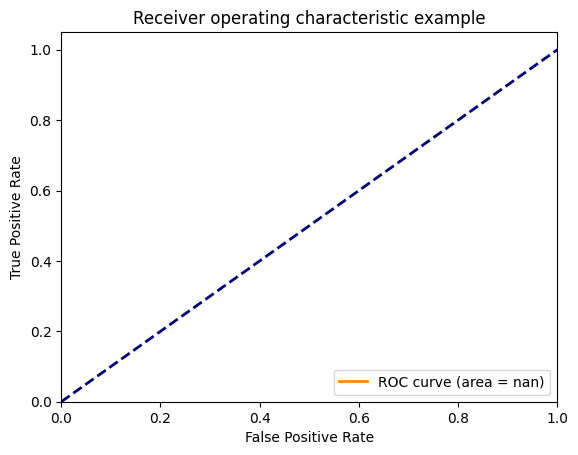

In [15]:
# 绘制 ROC 曲线
result = svm_classifier.predict(np.array(test_hog_list))[1].ravel()
fpr, tpr, thresholds = roc_curve(test_label_list, result)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 绘制 y=x 对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')  # 假正例率
plt.ylabel('True Positive Rate')  # 真正例率
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()